# Imports

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optparse import OptionParser
import seaborn as sns
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score
import os
import gc
import re
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [3]:
#text processing
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
import nltk

In [4]:
import torch
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
#tensorflow
import tensorflow as tf
import tensorflow_hub as hub
from official.nlp import optimization
import tensorflow_text as text

# Utils

In [6]:
def sent_trans(x):
    temp=[]
    for i in x.split():
        if (i.startswith('@') or i.startswith('#')):
            continue
        else:
            temp.append(i)
    return ' '.join(temp)

# Loading data

from four sources:
- airline tweets
- govt tweets
- financial news
- sentiment140 dataset

## Airline

In [7]:
airline=pd.read_csv('./../data/airlinetweets.csv')
airline=airline[['text','sentiment']]

In [8]:
airline['set'] = 'airline'

In [9]:
airline.head()

,text,sentiment,set
0,@VirginAmerica What @dhepburn said.,neutral,airline
1,@VirginAmerica plus you've added commercials t...,positive,airline
2,@VirginAmerica I didn't today... Must mean I n...,neutral,airline
3,@VirginAmerica it's really aggressive to blast...,negative,airline
4,@VirginAmerica and it's a really big bad thing...,negative,airline


## Indian Government

In [10]:
govt=pd.read_csv('../data/indiangovttweet.csv')


In [11]:
govt['set'] = 'govt'

In [12]:
govt.head()

,text,sentiment,set
0,when modi promised “minimum government maximum...,-1.0,govt
1,talk all the nonsense and continue all the dra...,0.0,govt
2,what did just say vote for modi welcome bjp t...,1.0,govt
3,asking his supporters prefix chowkidar their n...,1.0,govt
4,answer who among these the most powerful world...,1.0,govt


## Financial

In [13]:
financial=pd.read_csv('../data/financialnews.csv',encoding='ISO-8859-1')
financial=financial[['text','sentiment']]

In [14]:
financial['set'] = 'financial'

In [15]:
financial

,text,sentiment,set
0,"According to Gran , the company has no plans t...",neutral,financial
1,Technopolis plans to develop in stages an area...,neutral,financial
2,The international electronic industry company ...,negative,financial
3,With the new production plant the company woul...,positive,financial
4,According to the company 's updated strategy f...,positive,financial
...,...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,negative,financial
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,neutral,financial
4843,Operating profit fell to EUR 35.4 mn from EUR ...,negative,financial
4844,Net sales of the Paper segment decreased to EU...,negative,financial


In [16]:
print(airline.shape,financial.shape,govt.shape)

(14640, 3) (4846, 3) (162980, 3)


# Join

In [17]:
data=pd.concat([airline,govt,financial],axis=0)

In [18]:
label_dict={'neutral':0, 'positive':1, 'negative':-1,
            '0':0, '1':1, '-1':-1,
            0:0, 1:1, -1:-1}
data.sentiment=data.sentiment.map(label_dict)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182466 entries, 0 to 4845
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   text       182462 non-null  object 
 1   sentiment  182459 non-null  float64
 2   set        182466 non-null  object 
dtypes: float64(1), object(2)
memory usage: 5.6+ MB


C:\Anaconda3\envs\pytorch\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sentiment', ylabel='count'>

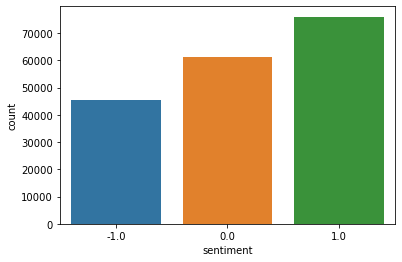

In [20]:
sns.countplot(data.sentiment)

# Cleaning

## Converting everything to string

In [21]:
data['text'] = data['text'].apply(lambda x: str(x))

## Define cleaning function to remove @, useless encoding, and all the numbers and symbols

In [22]:
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def text_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    clean = clean.replace("'","")
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    
    # tokenize and recombine to get rid of whitespaces
    words = tok.tokenize(lower_case)
    
    return (" ".join(words)).strip()

In [23]:
clean_text=[]
for i in tqdm(data['text']):
    clean_text.append(text_cleaner(i))

<ipython-input-23-a2e62b0646b8>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(data['text']):


  0%|          | 0/182466 [00:00<?, ?it/s]

In [24]:
data['text']=clean_text

In [ ]:
data.to_csv('../data/cleaned_data_bert_sentiment.csv')

## Optional preload clean dataset

In [3]:
data = pd.read_csv('../data/cleaned_data_bert_sentiment.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

In [140]:
data.head()

,text,sentiment,set,len,words
0,what said,0.0,airline,9,2
1,plus youve added commercials to the experience...,1.0,airline,52,8
2,i didnt today must mean i need to take another...,0.0,airline,51,11
3,its really aggressive to blast obnoxious enter...,-1.0,airline,101,15
4,and its a really big bad thing about it,-1.0,airline,39,9


## Eliminate rows that have less than 3 characters

In [25]:
data.dropna(inplace=True)

In [26]:
data['len'] = data['text'].apply(len)

In [27]:
data['words'] = data['text'].apply(lambda x: len(x.split()))

In [28]:
data.drop(data[data['len']<=3].index,inplace=True)

In [29]:
data.reset_index(drop=True,inplace=True)

# Bert Using simpletransformers

In [31]:
import re
import unicodedata
import multiprocessing
import emoji
import sys

CUSTOM_TABLE = str.maketrans(
    {
        "\xad": None,
        "\x7f": None,
        "\ufeff": None,
        "\u200b": None,
        "\u200e": None,
        "\u202a": None,
        "\u202c": None,
        "‘": "'",
        "’": "'",
        "`": "'",
        "“": '"',
        "”": '"',
        "«": '"',
        "»": '"',
        "ɢ": "G",
        "ɪ": "I",
        "ɴ": "N",
        "ʀ": "R",
        "ʏ": "Y",
        "ʙ": "B",
        "ʜ": "H",
        "ʟ": "L",
        "ғ": "F",
        "ᴀ": "A",
        "ᴄ": "C",
        "ᴅ": "D",
        "ᴇ": "E",
        "ᴊ": "J",
        "ᴋ": "K",
        "ᴍ": "M",
        "Μ": "M",
        "ᴏ": "O",
        "ᴘ": "P",
        "ᴛ": "T",
        "ᴜ": "U",
        "ᴡ": "W",
        "ᴠ": "V",
        "ĸ": "K",
        "в": "B",
        "м": "M",
        "н": "H",
        "т": "T",
        "ѕ": "S",
        "—": "-",
        "–": "-",
    }
)

WORDS_REPLACER =[ 
    ("aren't" , "are not"),
    ("can't" , "cannot"),
    ("couldn't" , "could not"),
    ("couldnt" , "could not"),
    ("didn't" , "did not"),
    ("doesn't" , "does not"),
    ("doesnt" , "does not"),
    ("don't" , "do not"),
    ("hadn't" , "had not"),
    ("hasn't" , "has not"),
    ("haven't" , "have not"),
    ("havent" , "have not"),
    ("he'd" , "he would"),
    ("he'll" , "he will"),
    ("he's" , "he is"),
    ("i'd" , "I would"),
    ("i'd" , "I had"),
    ("i'll" , "I will"),
    ("i'm" , "I am"),
    ("isn't" , "is not"),
    ("it's" , "it is"),
    ("it'll","it will"),
    ("i've" , "I have"),
    ("let's" , "let us"),
    ("mightn't" , "might not"),
    ("mustn't" , "must not"),
    ("shan't" , "shall not"),
    ("she'd" , "she would"),
    ("she'll" , "she will"),
    ("she's" , "she is"),
    ("shouldn't" , "should not"),
    ("shouldnt" , "should not"),
    ("that's" , "that is"),
    ("thats" , "that is"),
    ("there's" , "there is"),
    ("theres" , "there is"),
    ("they'd" , "they would"),
    ("they'll" , "they will"),
    ("they're" , "they are"),
    ("theyre",  "they are"),
    ("they've" , "they have"),
    ("we'd" , "we would"),
    ("we're" , "we are"),
    ("weren't" , "were not"),
    ("we've" , "we have"),
    ("what'll" , "what will"),
    ("what're" , "what are"),
    ("what's" , "what is"),
    ("what've" , "what have"),
    ("where's" , "where is"),
    ("who'd" , "who would"),
    ("who'll" , "who will"),
    ("who're" , "who are"),
    ("who's" , "who is"),
    ("who've" , "who have"),
    ("won't" , "will not"),
    ("wouldn't" , "would not"),
    ("you'd" , "you would"),
    ("you'll" , "you will"),
    ("you're" , "you are"),
    ("you've" , "you have"),
    ("'re", " are"),
    ("wasn't", "was not"),
    ("we'll"," will"),
    ("didn't", "did not"),
    ("tryin'","trying")
]



REGEX_REPLACER = [
    (re.compile(pat.replace("*", "\*"), flags=re.IGNORECASE), repl)
    for pat, repl in WORDS_REPLACER
]

RE_SPACE = re.compile(r"\s")
RE_MULTI_SPACE = re.compile(r"\s+")

NMS_TABLE = dict.fromkeys(
    i for i in range(sys.maxunicode + 1) if unicodedata.category(chr(i)) == "Mn"
)

HEBREW_TABLE = {i: "א" for i in range(0x0590, 0x05FF)}
ARABIC_TABLE = {i: "ا" for i in range(0x0600, 0x06FF)}
CHINESE_TABLE = {i: "是" for i in range(0x4E00, 0x9FFF)}
KANJI_TABLE = {i: "ッ" for i in range(0x2E80, 0x2FD5)}
HIRAGANA_TABLE = {i: "ッ" for i in range(0x3041, 0x3096)}
KATAKANA_TABLE = {i: "ッ" for i in range(0x30A0, 0x30FF)}

TABLE = dict()
TABLE.update(CUSTOM_TABLE)
TABLE.update(NMS_TABLE)
# Non-english languages
TABLE.update(CHINESE_TABLE)
TABLE.update(HEBREW_TABLE)
TABLE.update(ARABIC_TABLE)
TABLE.update(HIRAGANA_TABLE)
TABLE.update(KATAKANA_TABLE)
TABLE.update(KANJI_TABLE)


EMOJI_REGEXP = emoji.get_emoji_regexp()

UNICODE_EMOJI_MY = {
    k: f" EMJ {v.strip(':').replace('_', ' ')} "
    for k, v in emoji.UNICODE_EMOJI_ALIAS_ENGLISH.items()
}


def my_demojize(string: str) -> str:
    def replace(match):
        return UNICODE_EMOJI_MY.get(match.group(0), match.group(0))

    return re.sub("\ufe0f", "", EMOJI_REGEXP.sub(replace, string))


def normalize(text: str) -> str:
    text = my_demojize(text)

    text = RE_SPACE.sub(" ", text)
    text = unicodedata.normalize("NFKD", text)
    text = text.translate(TABLE)
    text = RE_MULTI_SPACE.sub(" ", text).strip()

    for pattern, repl in REGEX_REPLACER:
        text = pattern.sub(repl, text)

    return text


In [32]:
data['text'] = data['text'].apply(normalize)

In [33]:
data['sentiment'] = pd.Categorical(data['sentiment'])
data['sentiment'] = data.sentiment.cat.codes

In [34]:
data.sentiment.unique()

array([1, 2, 0], dtype=int8)

In [35]:
splitter = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=2020)

In [36]:
for train_ind, test_ind in splitter.split(data['text'],data['sentiment']):
    x_train = data['text'].iloc[train_ind]
    x_test = data['text'].iloc[test_ind]
    
    y_train = data['sentiment'].iloc[train_ind]
    y_test = data['sentiment'].iloc[test_ind]

In [37]:
bert_train_df=pd.DataFrame(columns=['text','label'])
bert_train_df['text']=x_train
bert_train_df['label']=y_train

bert_test_df=pd.DataFrame(columns=['text','label'])
bert_test_df['text']=x_test
bert_test_df['label']=y_test

In [38]:
bert_train_df.reset_index(inplace=True,drop=True)
bert_train_df.to_feather('../data/bert_train_sentiment.ftr')

bert_test_df.reset_index(inplace=True,drop=True)
bert_test_df.to_feather('../data/bert_test_sentiment.ftr')

**Reload data here**

In [5]:
bert_train_df=pd.read_feather('./../data/bert_train_sentiment.ftr')
bert_test_df=pd.read_feather('./../data/bert_test_sentiment.ftr')

In [6]:
model = ClassificationModel('roberta', 'roberta-base', num_labels=bert_train_df['label'].nunique())

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [7]:
torch.cuda.empty_cache()

In [8]:
model.train_model(bert_train_df, args={'fp16': False, 'num_train_epochs': 2, 'reprocess_input_data': True, 'overwrite_output_dir': True, 'dataloader_num_workers':0, 'train_batch_size':32})

C:\Anaconda3\envs\pytorch\lib\site-packages\simpletransformers\classification\classification_model.py:445: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/21 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/4561 [00:00<?, ?it/s]

C:\Anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running Epoch 1 of 2:   0%|          | 0/4561 [00:00<?, ?it/s]

(9122, 0.2297732650091879)

In [10]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')
    
result, model_outputs, wrong_predictions = model.eval_model(bert_test_df, f1=f1_multiclass, acc=accuracy_score)

C:\Anaconda3\envs\pytorch\lib\site-packages\simpletransformers\classification\classification_model.py:1025: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


Running Evaluation:   0%|          | 0/4561 [00:00<?, ?it/s]

In [11]:
result

{'mcc': 0.939903324196748,
 'f1': 0.9607773270474729,
 'acc': 0.9607773270474729,
 'eval_loss': 0.13835199280416902}

# Tensorlfow Implementation

## Save dataset to load as tensorflow dataset

In [144]:
file_label_pairs = [('positive.txt',1),('negative.txt',-1),('neutral.txt',0)]

for file,label in file_label_pairs:
    with open('../data/'+file, "w") as my_output_file:
            [ my_output_file.write(text+'\n') for text in data[data['sentiment']==label]['text'].values]
    my_output_file.close()

In [145]:
def labeler(example, index):
    return example, tf.cast(index, tf.int64)

labeled_data_sets = []

for i, file_name in enumerate(['../data/positive.txt','../data/negative.txt']):
    lines_dataset = tf.data.TextLineDataset(str(file_name))
    labeled_dataset = lines_dataset.map(lambda ex: labeler(ex, i))
    labeled_data_sets.append(labeled_dataset)

In [146]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128
TRAIN_SIZE = int(data.shape[0]*0.8)
VALIDATION_SIZE = int(data.shape[0]*0.1)
TEST_SIZE = data.shape[0]-(TRAIN_SIZE + VALIDATION_SIZE)

In [147]:
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)

all_labeled_data = all_labeled_data.shuffle(
    BUFFER_SIZE, reshuffle_each_iteration=False)

In [148]:
for text, label in all_labeled_data.take(10):
    print("Sentence: ", text.numpy())
    print("Label:", label.numpy())

Sentence:  b'yogi one kids modi one kids advani one kids togadia one kids bal thackeray one kids but muslims produce too many children'
Label: 0
Sentence:  b'the idea bjp keep you busy throughout election time with low level people like that you can not concentrate real issues which exposes modi govt therefore please conc putting real issues front people thank'
Label: 0
Sentence:  b'wow never knew this was possible kudos the scientist and technicians who were involved this project hail modi more power and godspeed hiss achievements'
Label: 0
Sentence:  b'the person under whom npa was the highest and couldnt detect scam loans given mallya and nirav modi should per you awesome'
Label: 0
Sentence:  b'who was responsible modi thought its drdo'
Label: 0
Sentence:  b'proud our narendra modi'
Label: 0
Sentence:  b'yeah haha never been in one its expensive and we will so much fun destinationdragons'
Label: 0
Sentence:  b'modi transforming india this video needs super viral please spread this a

## Split into train val and test

In [149]:
train_dataset = all_labeled_data.take(TRAIN_SIZE)
test_dataset = all_labeled_data.skip(TRAIN_SIZE)
val_dataset = test_dataset.skip(VALIDATION_SIZE)
test_dataset = test_dataset.take(TEST_SIZE)

In [150]:
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Load bert preprocessor and model

In [151]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [152]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [153]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [154]:
def build_bert_classifier():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='bert_encoder')
    outputs = encoder(encoder_inputs)
    x = outputs['pooled_output']
    x = tf.keras.layers.Dropout(0.1)(x)
    output = tf.keras.layers.Dense(1, activation=None, name='classifier')(x)
    return tf.keras.Model(text_input, output)

## Define model and train on the data

In [155]:
model = build_bert_classifier()

In [156]:
tf.keras.utils.plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [157]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = tf.keras.metrics.BinaryAccuracy()

In [158]:
epochs = 3
num_batches = int(TRAIN_SIZE/BATCH_SIZE)
num_train_steps = num_batches * epochs
num_warmup_steps = int(0.1*num_train_steps)

In [159]:
init_lr=3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [160]:
history = model.fit(x=train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs)

Epoch 1/3
948/948 [==============================] - 585s 613ms/step - loss: 1.2950 - binary_accuracy: 0.8093
Epoch 2/3
948/948 [==============================] - 575s 606ms/step - loss: 0.8120 - binary_accuracy: 0.8899
Epoch 3/3
948/948 [==============================] - 571s 602ms/step - loss: 0.5073 - binary_accuracy: 0.9204
